# The Rise and Fall of Different Music Genres
#### By: Will Slotterback, Erik Ryde, and Todd Roberts
In deciding what to work on for this project we first thought about interesting datasets we could use. One dataset which came to mind was the Billboard Hot 100. Billboard has been tracking the top 100 most popular songs in the U.S. every week since the late 50's so they've amassed a massive dataset of musical tastes in the U.S. This data already provides a really interesting picture of changing preferences in the U.S. but on its own its hard to tease out broad musical trends. To do this we need a way to categorize the different songs. The obvious choice is to do it by genre, but Billboard doesn't have data on the genre of song, just its popularity. To get this data we instead need to turn to the Spotify API where we can correlate the genre of an artist with songs that artist has produced. Though this isn't a perfect method -- artists do often cross genres and produce new types of songs -- it is accurate enough to produce valuable results. Using this data we can then plot the rise and fall of different musical genres in American history and understand questions like: What is the most popular genre of all time? Spoiler: It's not Ska.

## 1. Gathering our Data
The first step in collecting our data is scraping the Billboard Hot 100 to gather the list of most popular songs. Billboard used to provide an API for this, but has since deprecated it, so we chose instead to use the [billboard-top-100](https://github.com/darthbatman/billboard-top-100) library. Billboard chart urls follow the predictable pattern of `billboard.com/charts/*chart_name*/*date*` so this library takes a chart name, and a date, and scrapes the HTML for that chart in order to produce a list of the songs in that chart. We wrote a utility function around this  that allowed us to fetch all of the charts starting from a specific date and write them to a file. This function (and a few other utility functions) can be seen in our [source](https://github.com/slotterbackW/music-genres/blob/master/billboard-api/billboard.js).

Running this function with the date: *August 9th, 1958* or the earliest date Billboard charts are available produced a very large dataset, as you can see below.

In [1]:
with open('./data/songs.txt') as songs_file:
    list_of_songs = songs_file.readlines()
    print(len(list_of_songs))

314501


Wow that's a lot of music! For reference the average song is about three minutes long, so if you listened to all the songs in our dataset one after another it would take you 655 days, or over a year and a half.

Our dataset is not complete, however. We want to be able to look at broad trends in the data we have, but right now the individual songs are too granular. We need to categorize these songs by their genre. As mentioned above, to do this we'll use the Spotify API to fetch the genre for a song's artist and then correlate that with the song. Unfortunately our data isn't the cleanest right now, so before we fetch genre's we need to clean it up a little bit.

The first problem with our data is that the artist names we have don't always represent one artist. For example the 1960's classic *Stuck On You* lists "Elvis Presley With The Jordanaires" as the artist. As is obvious to human reader this is actually two artists, *Elvis Presley* and *The Jordanaires*, but the computer doesn't know that. Our method for solving this is to split artist names on a series of delimeters, and say that a song is officially by the first artist in that list.

The other issue with our data is that there are lots of duplicates. Because especially successful songs will last on the Hot 100 chart for many weeks the same song could show up multiple times. We don't want to waste resources fetching the same artist name multiple times, so making sure the names of artists we have are unique is an important concern of ours.

Ok let's get into some code. The first thing we'll do is grab the raw list of artists.

In [2]:
raw_artists = []
with open('./data/songs.txt') as songs_file:
    # Our data is separated by bar characters and artists are in column 2 (0-based)
    raw_artists = [line.split('|')[2] for line in songs_file]

Then we'll polish the raw artist data so that it only contains the primary artist we care about. To do this we'll use a method we wrote which splits a string based on a list of delimiters. [[source](https://github.com/slotterbackW/music-genres/blob/master/analysis_helpers.py#L20)]

As mentioned above, we also want to remove duplicates from this data so to do that we'll store the names of our artists in a dictionary.

In [3]:
DELIMITERS = ['and', 'with', 'featuring', 'ft.', 'ft', '&', 'X']
# .split() only takes one argument, so we wrote our own "multi_split" function
# which splits a string based on a list of delimiters
from analysis_helpers import multi_split

# Now we'll use the delimiters to split artist names and grab the first one
# We also want to remove duplicates so we'll use a dictionary to store the results
artists = {}
for raw_artist in raw_artists[1:]:
    # We don't care about the value so we just use 0
    artists[multi_split(raw_artist, DELIMITERS)[0]] = 0

Now that we have a collection of unique artist names the next step is to fetch the genres for those artists from the Spotify API. This is so that we can correlate the genre of an artist with their songs and eventually do our analysis. Our methodology for this is to use Spotify's search API to search for the name of the artist and then say that the first result returned is the artist we're looking for. We'll then grab the genres listed for that artist and write the artist's name and genres to a file. The result of this process (which you can see in our [source](https://github.com/slotterbackW/music-genres/blob/master/spotify.py#L25)) is shown below.

In [4]:
artist_genres = {}
with open('./data/artists.txt') as artists_file:
    header = artists_file.readline()
    for line in artists_file:
        split_line = line.strip().split('|')
        artist_genres[split_line[0]] = eval(split_line[2])
        

genre_dict = {}
for genres in artist_genres.values():
    for genre in genres:
        genre_dict[genre] = 0

print(len(list(genre_dict.keys())))
artist_genres

771


{'Ricky Nelson': ['adult standards',
  'brill building pop',
  'bubblegum pop',
  'christmas',
  'doo-wop',
  'folk rock',
  'lounge',
  'merseybeat',
  'nashville sound',
  'rhythm and blues',
  'rock-and-roll',
  'rockabilly'],
 'Domenico Modugno': ['classic italian pop', 'italian pop'],
 'Bobby Darin': ['adult standards',
  'brill building pop',
  'christmas',
  'easy listening',
  'lounge',
  'rock-and-roll',
  'rockabilly',
  'soul',
  'swing',
  'vocal jazz'],
 'Kalin Twins': [],
 'Jack Scott': ['brill building pop',
  'deep adult standards',
  'doo-wop',
  'rock-and-roll',
  'rockabilly'],
 'Elvis Presley': ['christmas', 'rock-and-roll', 'rockabilly'],
 'Duane Eddy': ['adult standards',
  'brill building pop',
  'christmas',
  'doo-wop',
  'rhythm and blues',
  'rock-and-roll',
  'rockabilly',
  'surf music'],
 'Jimmy Clanton': ['brill building pop',
  'doo-wop',
  'rhythm and blues',
  'swamp pop'],
 'The Coasters': ['adult standards',
  'brill building pop',
  'christmas',
  '

Now that we have aggregated all of the genres associated with our Billboard Hot 100 artists, we need to make sure that our song data, which contains the dates, is using the same artist names as the ones we cleaned above. This is done in our [source](https://github.com/slotterbackW/music-genres/blob/master/songs_cleaning.py) and rewritten to a new songs file, the results of which can be seen below.

In [5]:
with open('./data/cleaned_songs.txt') as cleaned_songs:
    songs_header = cleaned_songs.readline().strip().split('|')
    songs_data = [song.strip().split('|') for song in cleaned_songs.readlines()]
songs_data

[['1958-08-09', 'Poor Little Fool', 'Ricky Nelson', '1'],
 ['1958-08-09', 'Nel Blu Dipinto Di Blu (Volaré)', 'Domenico Modugno', '2'],
 ['1958-08-09', 'Patricia', 'Perez Prado', '3'],
 ['1958-08-09', 'Splish Splash', 'Bobby Darin', '4'],
 ['1958-08-09', 'When', 'Kalin Twins', '5'],
 ['1958-08-09', 'My True Love', 'Jack Scott', '6'],
 ['1958-08-09', 'Hard Headed Woman', 'Elvis Presley', '7'],
 ['1958-08-09', "Rebel-'rouser", 'Duane Eddy', '8'],
 ['1958-08-09', 'Just A Dream', 'Jimmy Clanton', '9'],
 ['1958-08-09', 'Willie And The Hand Jive', 'The Johnny Otis Show', '9'],
 ['1958-08-09', 'Yakety Yak', 'The Coasters', '11'],
 ['1958-08-09', 'If Dreams Came True', 'Pat Boone', '12'],
 ['1958-08-09', 'Fever', 'Peggy Lee', '13'],
 ['1958-08-09', 'Little Star', 'The Elegants', '14'],
 ['1958-08-09', 'Ginger Bread', 'Frankie Avalon', '15'],
 ['1958-08-09', 'Everybody Loves A Lover', 'Doris Day', '16'],
 ['1958-08-09', 'One Summer Night', 'The Danleers', '17'],
 ['1958-08-09', 'Born Too Late', 

## 2. Kowalski!
<br>
<div style="width: 500px;">![Kowalski, Analysis!](images/analysis.jpg)</div>

Let's start by creating a dictionary which maps years to a dictionary of songs and list of the song's rankings. We'll say that a song ranked at #1 gets a score of 100, #2 gets a 99 and so on. This will help us visualize the most popular songs of each year.


In [16]:
# Helper function to get the year from a date string
def get_year(date):
    return int(date.split('-')[0])

# Initialize current year variable to be the first year in the dataset
current_year = get_year(songs_data[0][0])
years_to_songs = {}
years_to_songs[current_year] = {}

for row in songs_data:
    row_year = get_year(row[0])
    song_name = row[1]
    if row_year != current_year:
        current_year = row_year
        years_to_songs[current_year] = {}
    if song_name in years_to_songs[current_year]:
        years_to_songs[current_year][song_name].append(int(row[3]))
    else:
        years_to_songs[current_year][song_name] = [int(row[3])]

# Now let's see the results
years_to_songs

{1958: {'Poor Little Fool': [1, 4, 6, 5, 6, 13, 19, 36, 47, 71],
  'Nel Blu Dipinto Di Blu (Volaré)': [2,
   1,
   2,
   1,
   1,
   1,
   1,
   2,
   4,
   6,
   12,
   14,
   18,
   57,
   88],
  'Patricia': [3, 5, 7, 6, 5, 11, 15, 20, 18, 30, 78, 73, 85],
  'Splish Splash': [4, 10, 16, 18, 45, 58, 72],
  'When': [5, 7, 10, 8, 21, 40, 64, 86],
  'My True Love': [6, 3, 5, 7, 7, 12, 13, 19, 24, 31, 63, 62, 94],
  'Hard Headed Woman': [7, 13, 21, 26, 56, 78, 94],
  "Rebel-'rouser": [8, 8, 11, 13, 19, 41, 52],
  'Just A Dream': [9, 5, 4, 4, 4, 5, 6, 9, 12, 14, 19, 29, 59, 86],
  'Willie And The Hand Jive': [9, 12, 12, 16, 17, 32, 42, 47, 67],
  'Yakety Yak': [11, 18, 35, 37, 74, 90],
  'If Dreams Came True': [12, 15, 18, 23, 24, 55, 82, 81, 82],
  'Fever': [13, 9, 8, 12, 12, 22, 33, 40, 38, 56, 83],
  'Little Star': [14, 2, 1, 2, 2, 3, 4, 5, 5, 8, 13, 13, 21, 40, 82, 78],
  'Ginger Bread': [15, 11, 17, 9, 9, 17, 27, 64, 66, 95],
  'Everybody Loves A Lover': [16, 14, 14, 19, 18, 19, 18, 2

Great, this will help us figure out what the most popular song of any given year is. As we mentioned before, the popularity of a song will be assessed as `101-RANK` meaning that the top song will earn 100 points for that week. The most popular song of the year will therefore be the song with the highest total adjusted popularity.

In [17]:
# Finds the most popular song of each year
# input: dictionary mapping song names to a list of their popularity scores
# output: dictionary mapping year to a tuple of top song name and its total score
def song_of_the_year(song_dict):
    max_score = 0
    max_song_name = ''
    for song, scores in song_dict.items():
        adjusted_scores = [101 - score for score in scores]
        total_song_score = sum(adjusted_scores)
        if total_song_score > max_score:
            max_score = total_song_score
            max_song_name = song
    return max_song_name, max_score

# Now let's use a dictionary comprehension and our new function
top_songs = {int(year):song_of_the_year(song_dict) for year, song_dict in years_to_songs.items()}

# Here are the results
top_songs

{1958: ("It's All In The Game", 1712),
 1959: ('The Battle Of New Orleans', 1752),
 1960: ('The Twist', 2330),
 1961: ("Tossin' And Turnin'", 1803),
 1962: ('Stranger On The Shore', 1948),
 1963: ('Days Of Wine And Roses', 1685),
 1964: ('Hello, Dolly!', 1840),
 1965: ('Red Roses For A Blue Lady', 2240),
 1966: ("California Dreamin'", 1265),
 1967: ("Groovin'", 1837),
 1968: ('Little Green Apples', 1767),
 1969: ('Sugar, Sugar', 1797),
 1970: ('Get Ready', 1489),
 1971: ("You've Got A Friend", 1898),
 1972: ('I Gotcha', 1621),
 1973: ('Why Me', 2142),
 1974: ('Come And Get Your Love', 1660),
 1975: ('Feelings', 1800),
 1976: ('A Fifth Of Beethoven', 2069),
 1977: ('I Just Want To Be Your Everything', 2361),
 1978: ('Hot Child In The City', 1964),
 1979: ('Sad Eyes', 1895),
 1980: ('Call Me', 1932),
 1981: ("Jessie's Girl", 2307),
 1982: ('Hurts So Good', 2165),
 1983: ('Flashdance...What A Feeling', 2025),
 1984: ("What's Love Got To Do With It", 1929),
 1985: ('Take On Me', 1605),
 19

Looking at the total popularity score of each top song, we might be interested in plotting those over time to see if there is a trend. To do this plotting, we're going to use a library called [Chartify](https://github.com/spotify/chartify/) which was developed by Spotify Labs. We chose this library becuause it makes creating prettier plots easier than many of its alternatives.

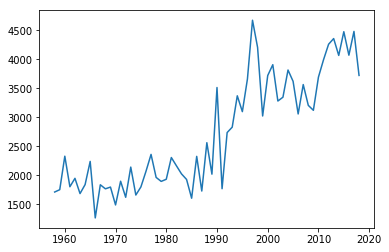

In [19]:
# ---AN EXAMPLE OF PLOTTING WITH MATPLOTLIB IN CASE WE WANT TO CHANGE---
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([[k] for k in top_songs.keys()], [v[1] for v in top_songs.values()])

In [13]:
# Chartify expects data in a Pandas DataFrame so we'll need to mess with it a bit
import pandas as pd

# To create a DataFrame from our dictionary while keeping the years
# in a usable format, we need to convert to a list
top_songs_by_year = [[int(k), str(k), v[0], v[1]] for k,v in top_songs.items()]
top_songs_by_year = pd.DataFrame(top_songs_by_year, columns=['YearInt', 'YearStr', 'SongTitle', 'PopularityScore'])

# This data looks nice in a table!
top_songs_by_year.head(10)

YearInt YearStr                  SongTitle  PopularityScore
0    1958    1958       It's All In The Game             1712
1    1959    1959  The Battle Of New Orleans             1752
2    1960    1960                  The Twist             2330
3    1961    1961        Tossin' And Turnin'             1803
4    1962    1962      Stranger On The Shore             1948
5    1963    1963     Days Of Wine And Roses             1685
6    1964    1964              Hello, Dolly!             1840
7    1965    1965  Red Roses For A Blue Lady             2240
8    1966    1966        California Dreamin'             1265
9    1967    1967                   Groovin'             1837

We also want to see if there's a relationship between the year and popularity score of the most popular song of the year. Maybe with the advent of the internet, the most popular stayed at the top of the charts for longer than ever before. Let's do some statistical analysis.

In [14]:
import statsmodels.formula.api as sm

# Let's check out our linear regression model results
top_model = sm.ols(formula='PopularityScore ~ YearInt', data=top_songs_by_year).fit()
print(top_model.summary())

# ...and add them to our DataFrame so we can plot the linear regression line too
top_songs_by_year['RegLine'] = [(year * top_model.params[1]) + top_model.params[0] for year in range(1958,2019,1)]
top_songs_by_year.head(10)

                            OLS Regression Results                            
Dep. Variable:        PopularityScore   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sat, 24 Nov 2018   Prob (F-statistic):                nan
Time:                        19:38:22   Log-Likelihood:                 1551.8
No. Observations:                  61   AIC:                            -2982.
Df Residuals:                       0   BIC:                            -2853.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1712.0000        inf     

/Users/willslotterback/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/willslotterback/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/Users/willslotterback/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/Users/willslotterback/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


YearInt YearStr                  SongTitle  PopularityScore  RegLine
0    1958    1958       It's All In The Game             1712  80032.0
1    1959    1959  The Battle Of New Orleans             1752  80072.0
2    1960    1960                  The Twist             2330  80112.0
3    1961    1961        Tossin' And Turnin'             1803  80152.0
4    1962    1962      Stranger On The Shore             1948  80192.0
5    1963    1963     Days Of Wine And Roses             1685  80232.0
6    1964    1964              Hello, Dolly!             1840  80272.0
7    1965    1965  Red Roses For A Blue Lady             2240  80312.0
8    1966    1966        California Dreamin'             1265  80352.0
9    1967    1967                   Groovin'             1837  80392.0

In [15]:
# Time to do some plotting
import chartify

# Here we set up our axis data types and make sure the chart labels exist
ch = chartify.Chart(blank_labels=True, 
                    x_axis_type='datetime', 
                    y_axis_type='linear')

# Let's set some labels
(ch.set_title("Popularity Score of Each Year's Most Popular Song Over Time")
.set_subtitle("Represents the most popular Billboard Top 100 song for each year."))

# ...and clean up our axes
(ch.axes.set_xaxis_label('Year')
.axes.set_yaxis_label('Popularity Score')
.axes.set_xaxis_range('1958', '2018')
.axes.set_xaxis_tick_values([str(top_songs_by_year['YearInt'].min()),
                             str(1970), str(1980), str(1990), str(2000), str(2010),
                             str(top_songs_by_year['YearInt'].max())]))
# Now we can plot
ch.plot.line(
    data_frame=top_songs_by_year,
    x_column='YearStr',
    y_column='PopularityScore')
ch.plot.line(
    data_frame=top_songs_by_year,
    x_column='YearStr',
    y_column='RegLine')

ch.callout.text('$R^2$={:.3f}'.format(top_model.rsquared),2010,3000)
ch.show()

Loading BokehJS ...